# XRF Data-Preprocessing
In this notebook, we are:<br>
   1) performing a running sum on the spectra from the raw XRF data to increase the signal to noise ratio <br>
   2) exporting it so that it can be re-reduced in Q-Spec<br>
   3) reimporting it and putting XRF measurements on a depth scale and selecting only the splice intervals<br>
   4) dropping a few extreme outliers from the results

# Import Packages

In [1340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import os

# Set Paths for Cores
The 10 GB of raw data are located on an external hardrive, this link will not work on github.

In [1341]:
U1474='/Volumes/DPBABIN/EXP361-U1474/'
U1478='/Volumes/DPBABIN/EXP361-U1478/'

# Get Core Names
I'll need to link to a directory in each core's file that has the raw spectra files

In [1342]:
U1474_sections=listdir(U1474)
U1474_sections.sort()
U1478_sections=listdir(U1478)

# Pre-Process Data
The steps for each core section (213 in all):<br>
1) Load all files in the section's directory as dataframes into a dictionary. <br>
2) Turn that dictionary into a single dataframe, where each column is one of the spectra. <br>
3) Do a 10-pt running sum of those spectra and selected every 10th one. This turns 10 spectra into one taller one. <br>
4) Turn that dataframe back into a a dictionary and a csv that Qspec can read.<br>
5) Write the resulting file into a directory on the external hardrive called 'New XRF Data"<br>
## U1474

In [283]:
for section in U1474_sections: 
    core=U1474+section+'/XRF data/'

    files=listdir(core)

    dct={}
    for file in files:
        dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')

    df=pd.DataFrame()
    for k in dct.keys():
        df[k]=dct[k].iloc[30:,0]

    summed=df.rolling(10,center=True,axis=1).sum()

    selected=summed.iloc[:,5:-5:10]

    product_dict={}
    for i in selected.columns.to_list():
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=selected[i]

    results_path='/Volumes/DPBABIN/EXP361-U1474/'+section+'/New XRF data/'
    os.mkdir(results_path)

    for key in product_dict:
        product_dict[key].to_csv(results_path+key,sep='\t')

## U1478

In [284]:
for section in U1478_sections: 
    core=U1478+section+'/XRF data/'

    files=listdir(core)

    dct={}
    for file in files:
        dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')

    df=pd.DataFrame()
    for k in dct.keys():
        df[k]=dct[k].iloc[30:,0]

    summed=df.rolling(10,center=True,axis=1).sum()

    selected=summed.iloc[:,5:-5:10]

    product_dict={}
    for i in selected.columns.to_list():
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=selected[i]

    results_path='/Volumes/DPBABIN/EXP361-U1478/'+section+'/New XRF data/'
    os.mkdir(results_path)

    for key in product_dict:
        product_dict[key].to_csv(results_path+key,sep='\t')

# Re-Reduction of Data in Q-Spec
The next step was to take these files and Q-spec to turn these spectra into peak areas and elemental intensities. The next figure compares the raw 2 second, 2 mm exposure with the integrated 2 second 2 cm exposure.

In [1347]:
core=U1474+section+'/XRF data/'
files=listdir(core)
dct={}
for file in files[:-1]:
    dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')
df=pd.DataFrame()
for k in dct.keys():
    df[k]=dct[k].iloc[30:,0]
summed=df.rolling(10,center=True,axis=1).sum()
selected=summed.iloc[:,5:-5:10]

## Results

In [1357]:
figure_path='/Users/danielbabin/Documents/GitHub/XRF_Data_Report/Figures/'

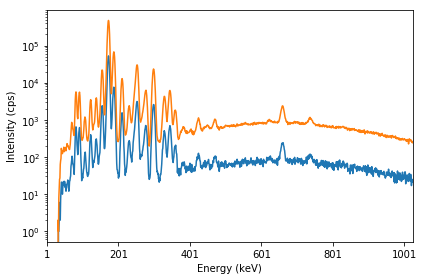

In [1360]:
fig,ax=plt.subplots()
df['L000005.spe'].astype(int).plot(ax=ax)
summed['L000005.spe'].astype(int).plot(ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Intensity (cps)')
ax.set_xlabel('Energy (keV)')
plt.tight_layout()
fig.savefig(figure_path+'integration.png',dpi=500)

# Results

In [1328]:
data_path='/Users/danielbabin/Documents/GitHub/XRF_Data_Report/Data/'

## Import Core Depth and Identification Details
I'll need this information to turn individual core positions from the XRF scanner into total core depths and piece together the splice. 

In [1329]:
splice=pd.read_csv(data_path+'splicedetail_24_9_2018.csv').iloc[0:57]
splice['CoreLabel']=(splice['Site']+splice['Hole']+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'Section Summary_11_11_2019.csv')
section_list['SectionLabel']=(section_list['Site']+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+section_list['Sect'].map(str))
section_list.rename(columns={'Top depth CCSF-361-U1474-ABDEF-20160220 (m)':'Top Depth CCSF (m)',
                            'Bottom depth CCSF-361-U1474-ABDEF-20160220 (m)':'Bottom Depth CCSF (m)'},inplace=True)

## Retrieve Data from Hardrive
Within this loop, I've also added section identifiers and top and bottom depths for each core. It's easy to do at this step because each dataframe is still only associated with one section. 

In [1330]:
dct={}
for i,section in enumerate(U1474_sections): 
    core=U1474+section+'/'

    dct[section]=pd.read_csv(core+'Results.txt',sep='\t',header=2)
    dct[section]['Section']=section[4:]
    dct[section]['Core']=section[4:-2]
    
    t=section_list[section_list.SectionLabel==section[4:]]['Top Depth CCSF (m)']
    b=section_list[section_list.SectionLabel==section[4:]]['Bottom Depth CCSF (m)']
    
    dct[section]['Top Depth CCSF (m)']=float(t)
    dct[section]['Bottom Depth CCSF (m)']=float(b)

## Concatenate Results into one DataFrame
I've also dropped the final measurement frome each section because usually the counts are low, due to low counts at the air at the end of the core.

In [1331]:
results=pd.DataFrame()
for section in U1474_sections:
    results=results.append(dct[section].iloc[:-1],sort=False)
nds=np.arange(len(results))
results['#']=nds
results=results.set_index('#')

## Turn "Position" into CCSF Depth

In [1332]:
results['Depth CCSF (m)']=results['position (mm)']/1000+results['Top Depth CCSF (m)']

## Select the Splice

In [1333]:
for i,core in enumerate(splice.CoreLabel):
    deeper=results.loc[results['Core']==core,'Depth CCSF (m)']>splice.loc[i,'Top depth CCSF (m)']
    shallower=results.loc[results['Core']==core,'Depth CCSF (m)']<splice.loc[i,'Bottom depth CCSF (m)']
    results.loc[results['Core']==core,'In Splice']=deeper&shallower

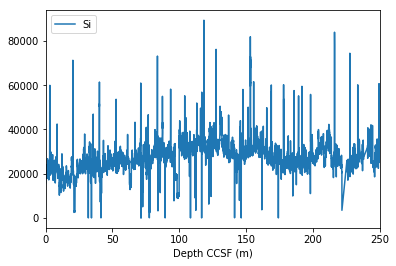

In [1334]:
fig,ax=plt.subplots()
results[results['In Splice']==True].plot(x='Depth CCSF (m)',y='Si',ax=ax)

# Final Cleaning
## Select important columns

In [1335]:
col_list=results.columns[:80].to_list()+results.columns[-2:].to_list()

In [1336]:
results['Depth CCSF (m)']=round(results['Depth CCSF (m)'].astype(float),2)
final=results[results['In Splice']==True][col_list].set_index('Depth CCSF (m)')

## Set Thresholds and Drop Cracks and Burps
Of some 10000 rows, 38 rows from 15 groups were dropped due to extreme outliers in the ratios.

In [1337]:
no_zero=final[final['Al']>400]
no_zero=no_zero[(no_zero[['Al','Si','K','Ca','Ti','Fe']] != 0).all(1)]
no_zero.drop([20.46,20.48,
              41.84,41.86,
              83.63,83.65,83.67,83.69,
              84.09,84.11,
              85.79,83.71,
              118.42,118.44,118.46,
              123.78,
              127.52,127.54,127.56,
              153.12,153.14,
              174.95,
              198.16,198.18,198.20,
              216.02,216.04,216.06,216.08,216.10,216.12,216.14,216.16,
              191.77,191.79,
              227.51,227.53,
              249.36],inplace=True)

# Export

In [1338]:
export=no_zero

In [1339]:
results_path='/Users/danielbabin/Documents/GitHub/XRF_Data_Report/Data/'
export.to_csv(results_path+'integrated_xrf_data_raw.csv')